# Plotting Hubble Residuals
 
Creates Hubble diagram and plots residuals

In [50]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from scipy.stats import chisquare
from scipy.optimize import minimize
from astropy.cosmology import Planck13 as cosmo

In [51]:
#read in data
sdss_combined = pd.read_csv('../results/sdss_combined.csv')

## Finding a Best Fit Cosmology

In [52]:
#define variables
Om0_assumed = cosmo.Om0
H0 = cosmo.H0
redshift = sdss_combined['zCMB'].to_numpy()
dist_mod = sdss_combined['muSALT2zspec'].to_numpy()
dist_mod_err = sdss_combined['muerrSALT2zspec'].to_numpy()

In [53]:
@np.vectorize

def chisq(x):
    '''defines chisq function which minimizes x offset'''
    model_dist_mod = cosmo.distmod(redshift).value + x
    return np.sum((dist_mod - model_dist_mod) ** 2 / dist_mod_err  ** 2)

In [55]:
#gets results of chisq minimization
fit_results = minimize(chisq, 0)
fit_results

      fun: 523.4437174661545
 hess_inv: array([[4.07615426e-06]])
      jac: array([4.57763672e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 16
      nit: 2
     njev: 5
   status: 2
  success: False
        x: array([-0.03146253])

## Plot Fit Results

In [56]:
def plot_hubble_diagram(z, mu, mu_err, x, figsize=(8, 12)):
    '''function to plot the hubble residuals'''
    
    xlim = np.min(z), np.max(z)
    z_plot = np.linspace(*xlim)
    fitted_dist_mod = cosmo.distmod(z_plot).value + x
    
    fig, (top_ax, bottom_ax) = plt.subplots(2, 1, sharex='col', figsize=figsize, gridspec_kw={'height_ratios': (2, 1)})
    plt.subplots_adjust(hspace=0)
    
    cosmology_style = dict(color='blue', alpha=0.5, label='$h=0.7,\ \Omega_M=0.3,\ \Omega_\Lambda=0.7$')
    mu_style = dict(fmt='none', color='red')
    
    top_ax.plot(z_plot, fitted_dist_mod, **cosmology_style)
    top_ax.errorbar(redshift, dist_mod, yerr=dist_mod_err, **mu_style)
    top_ax.set_ylabel('Distance Modulus (mag)')
    
    bottom_ax.axhline(0, **cosmology_style)
    bottom_ax.errorbar(z, mu - (cosmo.distmod(z).value + x), yerr=dist_mod_err, **mu_style)
    bottom_ax.set_xlim(*xlim)
    bottom_ax.set_xlabel('Redshift')
    bottom_ax.set_ylabel('Residuals')
    

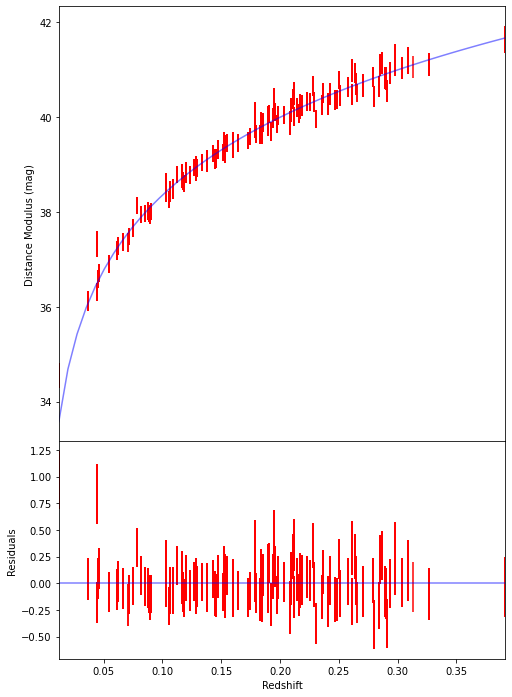

In [57]:
plot_hubble_diagram(redshift, dist_mod, dist_mod_err, fit_results.x[0])


In [58]:
#saves residuals to a new df in results file
resid = dist_mod - cosmo.distmod(redshift).value
sdss_combined['residuals'] = resid.tolist()
sdss_combined.to_csv('../results/residual_df.csv')